In [1]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt


# # Define the directory containing the images
# #test_image = "BPS-Microscopy/DAPI_MASK_images"
image_dir = "BPS-Microscopy/train"

# Load the metadata from the Excel file
# metadata_path = 'BPS-Microscopy/DAPI_MASK_images/meta_DAPI_MASK.csv'
metadata_path = 'BPS-Microscopy/train/meta.csv'
metadata = pd.read_csv(metadata_path)

# Display the first few rows of the metadata
# print(metadata.head())

# Add the full path to the filenames in the metadata
metadata['filepath'] = metadata['filename'].apply(lambda x: os.path.join(image_dir, x))

# Filter only tif
metadata = metadata[metadata['filename'].str.endswith('.tif')]

# Display the first few rows of the updated metadata
# metadata.head()


# Load the list of outlier file paths
outliers_file = "outliers_list.txt"  # Path to the saved outliers list
with open(outliers_file, "r") as f:
    outlier_filepaths = set(line.strip() for line in f)

print(f"Number of outliers to remove: {len(outlier_filepaths)}")

# Remove outliers from the metadata
filtered_metadata = metadata[~metadata['filepath'].isin(outlier_filepaths)]

# Print results
print(f"Original metadata size: {len(metadata)}")
print(f"Filtered metadata size: {len(filtered_metadata)}")

metadata = filtered_metadata

2024-11-24 00:26:39.982530: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732436800.113633 1206932 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732436800.152081 1206932 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-24 00:26:40.299338: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Number of outliers to remove: 27
Original metadata size: 77177
Filtered metadata size: 77150


In [2]:
from phasepack.phasecong import phasecong
from skimage.measure import shannon_entropy
from skimage.filters import sobel
from skimage import io
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pickle

def extract_features(image):
    """
    Extracts features required for BIQA:
    - Mean Phase Congruency (MPC)
    - Entropy of Phase Congruency (EPC)
    - Entropy of the Image (EDIS)
    - Mean Gradient Magnitude of the Image (MGDIS)
    
    Parameters:
    - image: np.array, input grayscale image

    Returns:
    - features: list of feature values [MPC, EPC, EDIS, MGDIS]
    """
    # Compute Phase Congruency
    pc_image, *_ = phasecong(image)
    mpc = np.mean(pc_image)
    epc = shannon_entropy(pc_image)

    # Compute Image Entropy
    edis = shannon_entropy(image)

    # Compute Mean Gradient Magnitude
    gradient_image = sobel(image)
    mgdis = np.mean(gradient_image)

    return [mpc, epc, edis, mgdis]

def prepare_feature_dataset(metadata):
    """
    Extract features and labels for a given dataset.
    """
    features = []
    labels = []
    for _, row in metadata.iterrows():
        image_path = row['filepath']  # Replace with the correct column name for image paths
        try:
            image = io.imread(image_path, as_gray=True)  # Load the image
            feature = extract_features(image)  # Extract features
            features.append(feature)
            labels.append(row['dose_Gy'])  # Replace 'dose' with your target column name
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")
    return np.array(features), np.array(labels)


def load_or_prepare_features(metadata, hr_post_exposure, particle_type):
    filtered_metadata = metadata[
        (metadata['hr_post_exposure'] == hr_post_exposure) &
        (metadata['particle_type'] == particle_type)
    ]
    processed_dir = "processed_features"

    # Define filenames dynamically based on filtering criteria
    train_path = os.path.join(processed_dir, f"train_hr{hr_post_exposure}_particle{particle_type}.pkl")
    val_path = os.path.join(processed_dir, f"val_hr{hr_post_exposure}_particle{particle_type}.pkl")
    test_path = os.path.join(processed_dir, f"test_hr{hr_post_exposure}_particle{particle_type}.pkl")

    if os.path.exists(train_path) and os.path.exists(val_path) and os.path.exists(test_path):
        print("Loading processed datasets and metadata...")
        with open(train_path, "rb") as f:
            X_train, y_train, train_metadata = pickle.load(f)
        with open(val_path, "rb") as f:
            X_val, y_val, val_metadata = pickle.load(f)
        with open(test_path, "rb") as f:
            X_test, y_test, test_metadata = pickle.load(f)
    else:
        print("Processed datasets not found. Calculating features...")

        # Shuffle and split metadata
        shuffled_metadata = filtered_metadata.sample(frac=1, random_state=42).reset_index(drop=True)
        train_size = int(len(shuffled_metadata) * 0.7)
        val_size = int(len(shuffled_metadata) * 0.2)

        train_metadata = shuffled_metadata[:train_size]
        val_metadata = shuffled_metadata[train_size:train_size + val_size]
        test_metadata = shuffled_metadata[train_size + val_size:]

        # Extract features and labels
        X_train, y_train = prepare_feature_dataset(train_metadata)
        X_val, y_val = prepare_feature_dataset(val_metadata)
        X_test, y_test = prepare_feature_dataset(test_metadata)

        # Normalize features
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)

        # Save datasets with metadata
        os.makedirs(processed_dir, exist_ok=True)
        with open(train_path, "wb") as f:
            pickle.dump((X_train, y_train, train_metadata), f)
        with open(val_path, "wb") as f:
            pickle.dump((X_val, y_val, val_metadata), f)
        with open(test_path, "wb") as f:
            pickle.dump((X_test, y_test, test_metadata), f)

    return X_train, y_train, X_val, y_val, X_test, y_test, train_metadata, val_metadata, test_metadata


# Define filtering criteria
hr_post_exposure = 4
particle_type = 'X-ray'

# Pass criteria explicitly to the function
X_train, y_train, X_val, y_val, X_test, y_test, train_metadata, val_metadata, test_metadata = load_or_prepare_features(
    metadata, hr_post_exposure, particle_type
)

print(f"Filtering Criteria - hr_post_exposure: {hr_post_exposure}, particle_type: {particle_type}")
print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")


Loading processed datasets and metadata...
Filtering Criteria - hr_post_exposure: 4, particle_type: X-ray
Train size: 9766, Validation size: 2790, Test size: 1396


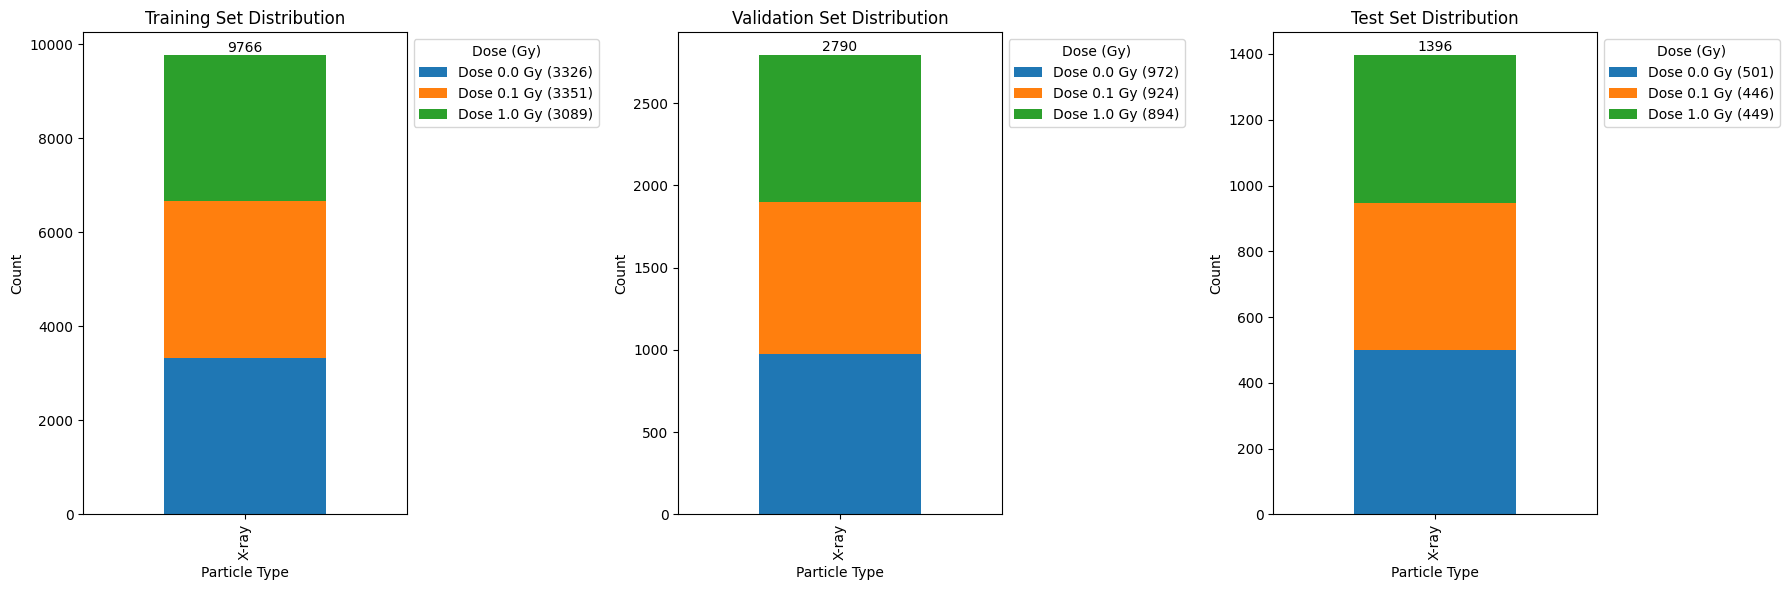

In [3]:
# Check set split

# Function to add total count annotations for each group
def annotate_group_totals(ax, data):
    for i, patch in enumerate(ax.patches):
        if i % len(data.columns) == 0:  # Add annotation only for the first bar of each group
            x = patch.get_x() + patch.get_width() / 2
            total = data.iloc[i // len(data.columns)].sum()
            ax.annotate(f'{int(total)}', (x, total + 5), ha='center', va='bottom', fontsize=10, color='black')

# Function to create legend labels with counts
def create_legend_labels(data):
    labels = []
    for dose in data.columns:
        count = data[dose].sum()
        labels.append(f"Dose {dose} Gy ({int(count)})")
    return labels

# Plot all sets: training, validation, and test
plt.figure(figsize=(18, 6))

# Training set plot
plt.subplot(1, 3, 1)
train_counts = train_metadata.groupby(['particle_type', 'dose_Gy']).size().unstack().fillna(0)
train_ax = train_counts.plot(kind='bar', stacked=True, ax=plt.gca(), legend=False)
annotate_group_totals(train_ax, train_counts)
plt.title('Training Set Distribution')
plt.xlabel('Particle Type')
plt.ylabel('Count')

# Add legend with counts for training set
train_labels = create_legend_labels(train_counts)
plt.legend(train_labels, title="Dose (Gy)", bbox_to_anchor=(1.0, 1.0), loc='upper left')

# Validation set plot
plt.subplot(1, 3, 2)
val_counts = val_metadata.groupby(['particle_type', 'dose_Gy']).size().unstack().fillna(0)
val_ax = val_counts.plot(kind='bar', stacked=True, ax=plt.gca(), legend=False)
annotate_group_totals(val_ax, val_counts)
plt.title('Validation Set Distribution')
plt.xlabel('Particle Type')
plt.ylabel('Count')

# Add legend with counts for validation set
val_labels = create_legend_labels(val_counts)
plt.legend(val_labels, title="Dose (Gy)", bbox_to_anchor=(1.0, 1.0), loc='upper left')

# Test set plot
plt.subplot(1, 3, 3)
test_counts = test_metadata.groupby(['particle_type', 'dose_Gy']).size().unstack().fillna(0)
test_ax = test_counts.plot(kind='bar', stacked=True, ax=plt.gca(), legend=False)
annotate_group_totals(test_ax, test_counts)
plt.title('Test Set Distribution')
plt.xlabel('Particle Type')
plt.ylabel('Count')

# Add legend with counts for test set
test_labels = create_legend_labels(test_counts)
plt.legend(test_labels, title="Dose (Gy)", bbox_to_anchor=(1.0, 1.0), loc='upper left')

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
# Import required libraries
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score, mean_absolute_error

# Sweep Configuration for activation functions and loss functions
sweep_config = {
    'method': 'grid',  # Options: 'grid', 'random', 'bayes'
    'metric': {
        'name': 'val_mae',  # Metric to optimize
        'goal': 'minimize'
    },
    'parameters': {
        'learning_rate': {
            'values': [0.001, 0.005, 0.01]
        },
        'batch_size': {
            'values': [16, 32]
        },
        'epochs': {
            'values': [20, 25, 30, 35]
        },
        'input_dim': {
            'values': [4]  # Fixed as features are static
        },
        'activation_function': {
            'values': ['tanh' ]  # Activation functions to sweep
        },
        'loss_function': {
            'values': ['mean_absolute_error']  # Loss functions to sweep
        }
    }
}


# Define GRNN-like network using Keras
def grnn(input_dim, learning_rate, activation_function, loss_function):
    """
    Build a GRNN-like network using Keras.

    Parameters:
    - input_dim: Number of input features
    - learning_rate: Learning rate for the optimizer
    - activation_function: Activation function for the layers
    - loss_function: Loss function to use for training

    Returns:
    - Compiled Keras model
    """
    inputs = layers.Input(shape=(input_dim,))
    pattern_layer = layers.Dense(64, activation=activation_function)(inputs)
    summation_layer = layers.Dense(32, activation=activation_function)(pattern_layer)
    outputs = layers.Dense(1, activation='linear')(summation_layer)
    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=loss_function,
        metrics=['mae']
    )
    return model


def train():
    # Initialize wandb for this sweep run
    with wandb.init() as run:
        config = run.config

        # Build and compile the model dynamically
        model = grnn(
            input_dim=config.input_dim,
            learning_rate=config.learning_rate,
            activation_function=config.activation_function,
            loss_function=config.loss_function
        )

        # Train the model
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=config.epochs,
            batch_size=config.batch_size,
            verbose=2,
            callbacks=[
                WandbMetricsLogger(log_freq="epoch"),
                WandbModelCheckpoint(filepath="model-checkpoints/sweep_model.epoch{epoch:02d}.keras")
            ]
        )

        # Log training and validation metrics for each epoch
        for epoch in range(config.epochs):
            wandb.log({
                "epoch": epoch,
                "train_loss": history.history['loss'][epoch],
                "val_loss": history.history['val_loss'][epoch],
                "val_mae": history.history['val_mae'][epoch],
                "train_mae": history.history['mae'][epoch]
            })

        # Evaluate the model on the test set
        test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
        wandb.log({"Test Loss": test_loss, "Test MAE": test_mae})

        # Predict using the model
        predicted_doses = model.predict(X_test).flatten()

        # Calculate R² and log additional metrics
        r2 = r2_score(y_test, predicted_doses)
        absolute_errors = np.abs(y_test - predicted_doses)
        wandb.log({
            "R²": r2,
            "Mean Absolute Error (Test)": np.mean(absolute_errors),
            "Max Absolute Error (Test)": np.max(absolute_errors)
        })


# Initialize the sweep and run the agent
sweep_id = wandb.sweep(sweep_config, project="dose-prediction")
wandb.agent(sweep_id, train)  # Adjust count as needed


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: uui2wa8p
Sweep URL: https://wandb.ai/walt_/dose-prediction/sweeps/uui2wa8p


wandb: Agent Starting Run: 51p8kpij with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	input_dim: 4
wandb: 	learning_rate: 0.001
wandb: 	loss_function: mean_absolute_error
wandb: Currently logged in as: walt_. Use `wandb login --relogin` to force relogin


I0000 00:00:1732436810.245052 1207284 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11214 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:33:00.0, compute capability: 8.6


Epoch 1/20


I0000 00:00:1732436817.775469 1207365 service.cc:148] XLA service 0x7feab8006190 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732436817.775604 1207365 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-11-24 00:26:57.816337: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732436817.915717 1207365 cuda_dnn.cc:529] Loaded cuDNN version 90501
I0000 00:00:1732436819.225780 1207365 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


611/611 - 6s - 10ms/step - loss: 0.2907 - mae: 0.2907 - val_loss: 0.2723 - val_mae: 0.2723
Epoch 2/20
611/611 - 2s - 3ms/step - loss: 0.2767 - mae: 0.2767 - val_loss: 0.2725 - val_mae: 0.2725
Epoch 3/20
611/611 - 1s - 2ms/step - loss: 0.2724 - mae: 0.2724 - val_loss: 0.2615 - val_mae: 0.2615
Epoch 4/20
611/611 - 1s - 2ms/step - loss: 0.2685 - mae: 0.2685 - val_loss: 0.2611 - val_mae: 0.2611
Epoch 5/20
611/611 - 1s - 2ms/step - loss: 0.2649 - mae: 0.2649 - val_loss: 0.2554 - val_mae: 0.2554
Epoch 6/20
611/611 - 1s - 2ms/step - loss: 0.2619 - mae: 0.2619 - val_loss: 0.2540 - val_mae: 0.2540
Epoch 7/20
611/611 - 1s - 2ms/step - loss: 0.2568 - mae: 0.2568 - val_loss: 0.2496 - val_mae: 0.2496
Epoch 8/20
611/611 - 2s - 2ms/step - loss: 0.2500 - mae: 0.2500 - val_loss: 0.2407 - val_mae: 0.2407
Epoch 9/20
611/611 - 1s - 2ms/step - loss: 0.2386 - mae: 0.2386 - val_loss: 0.2344 - val_mae: 0.2344
Epoch 10/20
611/611 - 1s - 2ms/step - loss: 0.2297 - mae: 0.2297 - val_loss: 0.2318 - val_mae: 0.2318

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▇▆▆▆▅▅▄▃▃▃▂▂▂▂▁▁▁▁
epoch/mae,█▇▇▆▆▆▅▅▄▃▃▃▂▂▂▂▁▁▁▁
epoch/val_loss,██▇▇▆▆▆▅▄▄▃▃▂▃▂▂▂▁▁▁


wandb: Agent Starting Run: 7983cqa3 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	input_dim: 4
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Epoch 1/20
611/611 - 3s - 5ms/step - loss: 0.2919 - mae: 0.2919 - val_loss: 0.2733 - val_mae: 0.2733
Epoch 2/20
611/611 - 2s - 3ms/step - loss: 0.2742 - mae: 0.2742 - val_loss: 0.2908 - val_mae: 0.2908
Epoch 3/20
611/611 - 2s - 3ms/step - loss: 0.2667 - mae: 0.2667 - val_loss: 0.2709 - val_mae: 0.2709
Epoch 4/20
611/611 - 1s - 2ms/step - loss: 0.2350 - mae: 0.2350 - val_loss: 0.2189 - val_mae: 0.2189
Epoch 5/20
611/611 - 1s - 2ms/step - loss: 0.2052 - mae: 0.2052 - val_loss: 0.1981 - val_mae: 0.1981
Epoch 6/20
611/611 - 1s - 2ms/step - loss: 0.1974 - mae: 0.1974 - val_loss: 0.1956 - val_mae: 0.1956
Epoch 7/20
611/611 - 1s - 2ms/step - loss: 0.1927 - mae: 0.1927 - val_loss: 0.2232 - val_mae: 0.2232
Epoch 8/20
611/611 - 1s - 2ms/step - loss: 0.1915 - mae: 0.1915 - val_loss: 0.1964 - val_mae: 0.1964
Epoch 9/20
611/611 - 1s - 2ms/step - loss: 0.1911 - mae: 0.1911 - val_loss: 0.1956 - val_mae: 0.1956
Epoch 10/20
611/611 - 1s - 2ms/step - loss: 0.1887 - mae: 0.1887 - val_loss: 0.2064 - val_m

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▁
epoch/mae,█▇▆▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▁
epoch/val_loss,▇█▇▃▂▂▃▂▂▂▁▁▁▁▁▁▁▃▁▁


wandb: Agent Starting Run: xvcn67q3 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	input_dim: 4
wandb: 	learning_rate: 0.01
wandb: 	loss_function: mean_absolute_error


Epoch 1/20
611/611 - 3s - 5ms/step - loss: 0.2966 - mae: 0.2966 - val_loss: 0.2615 - val_mae: 0.2615
Epoch 2/20
611/611 - 2s - 3ms/step - loss: 0.2286 - mae: 0.2286 - val_loss: 0.2184 - val_mae: 0.2184
Epoch 3/20
611/611 - 1s - 2ms/step - loss: 0.2093 - mae: 0.2093 - val_loss: 0.2039 - val_mae: 0.2039
Epoch 4/20
611/611 - 2s - 2ms/step - loss: 0.1991 - mae: 0.1991 - val_loss: 0.1994 - val_mae: 0.1994
Epoch 5/20
611/611 - 1s - 2ms/step - loss: 0.1942 - mae: 0.1942 - val_loss: 0.1969 - val_mae: 0.1969
Epoch 6/20
611/611 - 1s - 2ms/step - loss: 0.1991 - mae: 0.1991 - val_loss: 0.1941 - val_mae: 0.1941
Epoch 7/20
611/611 - 1s - 2ms/step - loss: 0.1950 - mae: 0.1950 - val_loss: 0.2048 - val_mae: 0.2048
Epoch 8/20
611/611 - 1s - 2ms/step - loss: 0.1949 - mae: 0.1949 - val_loss: 0.1870 - val_mae: 0.1870
Epoch 9/20
611/611 - 1s - 2ms/step - loss: 0.1935 - mae: 0.1935 - val_loss: 0.1926 - val_mae: 0.1926
Epoch 10/20
611/611 - 1s - 2ms/step - loss: 0.1930 - mae: 0.1930 - val_loss: 0.1969 - val_m

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/mae,█▄▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▄▃▂▂▂▃▁▂▂▁▁▂▂▁▁▃▁▂▁


wandb: Agent Starting Run: 1pz0e1q7 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 25
wandb: 	input_dim: 4
wandb: 	learning_rate: 0.001
wandb: 	loss_function: mean_absolute_error


Epoch 1/25
611/611 - 3s - 5ms/step - loss: 0.2925 - mae: 0.2925 - val_loss: 0.2820 - val_mae: 0.2820
Epoch 2/25
611/611 - 1s - 2ms/step - loss: 0.2780 - mae: 0.2780 - val_loss: 0.2731 - val_mae: 0.2731
Epoch 3/25
611/611 - 1s - 2ms/step - loss: 0.2708 - mae: 0.2708 - val_loss: 0.2682 - val_mae: 0.2682
Epoch 4/25
611/611 - 1s - 2ms/step - loss: 0.2660 - mae: 0.2660 - val_loss: 0.2580 - val_mae: 0.2580
Epoch 5/25
611/611 - 1s - 2ms/step - loss: 0.2636 - mae: 0.2636 - val_loss: 0.2578 - val_mae: 0.2578
Epoch 6/25
611/611 - 1s - 2ms/step - loss: 0.2613 - mae: 0.2613 - val_loss: 0.2654 - val_mae: 0.2654
Epoch 7/25
611/611 - 1s - 2ms/step - loss: 0.2609 - mae: 0.2609 - val_loss: 0.2561 - val_mae: 0.2561
Epoch 8/25
611/611 - 1s - 2ms/step - loss: 0.2599 - mae: 0.2599 - val_loss: 0.2586 - val_mae: 0.2586
Epoch 9/25
611/611 - 1s - 2ms/step - loss: 0.2593 - mae: 0.2593 - val_loss: 0.2620 - val_mae: 0.2620
Epoch 10/25
611/611 - 1s - 2ms/step - loss: 0.2546 - mae: 0.2546 - val_loss: 0.2457 - val_m

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
epoch/epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▇▆▆▆▆▆▆▅▅▃▃▃▂▂▂▂▂▁▁▁▁▁▁
epoch/mae,█▇▇▆▆▆▆▆▆▅▅▃▃▃▂▂▂▂▂▁▁▁▁▁▁
epoch/val_loss,█▇▇▆▆▇▆▆▆▅▄▄▃▂▂▂▂▂▁▁▂▁▁▁▁


wandb: Agent Starting Run: dddskat2 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 25
wandb: 	input_dim: 4
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Epoch 1/25
611/611 - 3s - 5ms/step - loss: 0.2933 - mae: 0.2933 - val_loss: 0.2703 - val_mae: 0.2703
Epoch 2/25
611/611 - 2s - 3ms/step - loss: 0.2504 - mae: 0.2504 - val_loss: 0.2441 - val_mae: 0.2441
Epoch 3/25
611/611 - 1s - 2ms/step - loss: 0.2162 - mae: 0.2162 - val_loss: 0.2213 - val_mae: 0.2213
Epoch 4/25
611/611 - 1s - 2ms/step - loss: 0.2036 - mae: 0.2036 - val_loss: 0.2023 - val_mae: 0.2023
Epoch 5/25
611/611 - 1s - 2ms/step - loss: 0.1984 - mae: 0.1984 - val_loss: 0.1961 - val_mae: 0.1961
Epoch 6/25
611/611 - 1s - 2ms/step - loss: 0.1937 - mae: 0.1937 - val_loss: 0.1955 - val_mae: 0.1955
Epoch 7/25
611/611 - 1s - 2ms/step - loss: 0.1915 - mae: 0.1915 - val_loss: 0.1911 - val_mae: 0.1911
Epoch 8/25
611/611 - 1s - 2ms/step - loss: 0.1903 - mae: 0.1903 - val_loss: 0.1895 - val_mae: 0.1895
Epoch 9/25
611/611 - 1s - 2ms/step - loss: 0.1920 - mae: 0.1920 - val_loss: 0.1938 - val_mae: 0.1938
Epoch 10/25
611/611 - 2s - 3ms/step - loss: 0.1892 - mae: 0.1892 - val_loss: 0.1901 - val_m

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
epoch/epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▃▃▂▂▂▂▂▂▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁
epoch/mae,█▅▃▃▂▂▂▂▂▂▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▆▄▂▂▂▁▁▂▁▂▃▁▁▂▁▁▁▁▁▁▁▂▁▂


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3o2rn9nq with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 25
wandb: 	input_dim: 4
wandb: 	learning_rate: 0.01
wandb: 	loss_function: mean_absolute_error


Epoch 1/25
611/611 - 3s - 5ms/step - loss: 0.2934 - mae: 0.2934 - val_loss: 0.2828 - val_mae: 0.2828
Epoch 2/25
611/611 - 1s - 2ms/step - loss: 0.2323 - mae: 0.2323 - val_loss: 0.2152 - val_mae: 0.2152
Epoch 3/25
611/611 - 1s - 2ms/step - loss: 0.2095 - mae: 0.2095 - val_loss: 0.2030 - val_mae: 0.2030
Epoch 4/25
611/611 - 1s - 2ms/step - loss: 0.2013 - mae: 0.2013 - val_loss: 0.2619 - val_mae: 0.2619
Epoch 5/25
611/611 - 1s - 2ms/step - loss: 0.1977 - mae: 0.1977 - val_loss: 0.1998 - val_mae: 0.1998
Epoch 6/25
611/611 - 2s - 3ms/step - loss: 0.1973 - mae: 0.1973 - val_loss: 0.1918 - val_mae: 0.1918
Epoch 7/25
611/611 - 2s - 3ms/step - loss: 0.1942 - mae: 0.1942 - val_loss: 0.1893 - val_mae: 0.1893
Epoch 8/25
611/611 - 1s - 2ms/step - loss: 0.1939 - mae: 0.1939 - val_loss: 0.1945 - val_mae: 0.1945
Epoch 9/25
611/611 - 1s - 2ms/step - loss: 0.1890 - mae: 0.1890 - val_loss: 0.1919 - val_mae: 0.1919
Epoch 10/25
611/611 - 1s - 2ms/step - loss: 0.1875 - mae: 0.1875 - val_loss: 0.2036 - val_m

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
epoch/epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▂▂▂▂▂▁▁▁▁▁▂▁▁▂▂▁▂▁▁▁▂▁
epoch/mae,█▄▃▂▂▂▂▂▁▁▁▁▁▂▁▁▂▂▁▂▁▁▁▂▁
epoch/val_loss,█▃▂▆▂▁▁▂▁▂▁▁▁▁▁▁▂▄▁▁▁▁▂▂▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: niqfwb9e with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 30
wandb: 	input_dim: 4
wandb: 	learning_rate: 0.001
wandb: 	loss_function: mean_absolute_error


Epoch 1/30
611/611 - 3s - 5ms/step - loss: 0.2909 - mae: 0.2909 - val_loss: 0.2745 - val_mae: 0.2745
Epoch 2/30
611/611 - 1s - 2ms/step - loss: 0.2777 - mae: 0.2777 - val_loss: 0.2842 - val_mae: 0.2842
Epoch 3/30
611/611 - 1s - 2ms/step - loss: 0.2695 - mae: 0.2695 - val_loss: 0.2811 - val_mae: 0.2811
Epoch 4/30
611/611 - 1s - 2ms/step - loss: 0.2659 - mae: 0.2659 - val_loss: 0.2770 - val_mae: 0.2770
Epoch 5/30
611/611 - 1s - 2ms/step - loss: 0.2638 - mae: 0.2638 - val_loss: 0.2577 - val_mae: 0.2577
Epoch 6/30
611/611 - 1s - 2ms/step - loss: 0.2619 - mae: 0.2619 - val_loss: 0.2570 - val_mae: 0.2570
Epoch 7/30
611/611 - 1s - 2ms/step - loss: 0.2611 - mae: 0.2611 - val_loss: 0.2540 - val_mae: 0.2540
Epoch 8/30
611/611 - 1s - 2ms/step - loss: 0.2577 - mae: 0.2577 - val_loss: 0.2505 - val_mae: 0.2505
Epoch 9/30
611/611 - 2s - 2ms/step - loss: 0.2496 - mae: 0.2496 - val_loss: 0.2392 - val_mae: 0.2392
Epoch 10/30
611/611 - 1s - 2ms/step - loss: 0.2384 - mae: 0.2384 - val_loss: 0.2463 - val_m

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▇▆▆▆▆▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch/mae,█▇▇▆▆▆▆▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch/val_loss,▇██▇▆▆▆▅▅▅▄▃▃▃▃▃▂▃▂▂▂▂▁▁▁▁▂▁▁▁


wandb: Agent Starting Run: hxhy0u1t with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 30
wandb: 	input_dim: 4
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Epoch 1/30
611/611 - 3s - 5ms/step - loss: 0.2892 - mae: 0.2892 - val_loss: 0.2738 - val_mae: 0.2738
Epoch 2/30
611/611 - 1s - 2ms/step - loss: 0.2639 - mae: 0.2639 - val_loss: 0.2308 - val_mae: 0.2308
Epoch 3/30
611/611 - 1s - 2ms/step - loss: 0.2188 - mae: 0.2188 - val_loss: 0.2218 - val_mae: 0.2218
Epoch 4/30
611/611 - 1s - 2ms/step - loss: 0.2075 - mae: 0.2075 - val_loss: 0.2063 - val_mae: 0.2063
Epoch 5/30
611/611 - 1s - 2ms/step - loss: 0.2007 - mae: 0.2007 - val_loss: 0.2049 - val_mae: 0.2049
Epoch 6/30
611/611 - 1s - 2ms/step - loss: 0.1970 - mae: 0.1970 - val_loss: 0.2066 - val_mae: 0.2066
Epoch 7/30
611/611 - 1s - 2ms/step - loss: 0.1940 - mae: 0.1940 - val_loss: 0.1999 - val_mae: 0.1999
Epoch 8/30
611/611 - 2s - 3ms/step - loss: 0.1899 - mae: 0.1899 - val_loss: 0.1980 - val_mae: 0.1980
Epoch 9/30
611/611 - 2s - 3ms/step - loss: 0.1910 - mae: 0.1910 - val_loss: 0.1958 - val_mae: 0.1958
Epoch 10/30
611/611 - 2s - 3ms/step - loss: 0.1913 - mae: 0.1913 - val_loss: 0.2397 - val_m

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▃▃▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/mae,█▆▃▃▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▅▄▃▃▃▂▂▂▅▁▁▁▂▁▁▁▂▁▂▁▂▁▂▃▁▁▁▁▂


wandb: Agent Starting Run: ae2s0lhb with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 30
wandb: 	input_dim: 4
wandb: 	learning_rate: 0.01
wandb: 	loss_function: mean_absolute_error


Epoch 1/30
611/611 - 3s - 5ms/step - loss: 0.2919 - mae: 0.2919 - val_loss: 0.2660 - val_mae: 0.2660
Epoch 2/30
611/611 - 1s - 2ms/step - loss: 0.2750 - mae: 0.2750 - val_loss: 0.2595 - val_mae: 0.2595
Epoch 3/30
611/611 - 1s - 2ms/step - loss: 0.2154 - mae: 0.2154 - val_loss: 0.2097 - val_mae: 0.2097
Epoch 4/30
611/611 - 1s - 2ms/step - loss: 0.2067 - mae: 0.2067 - val_loss: 0.2097 - val_mae: 0.2097
Epoch 5/30
611/611 - 2s - 3ms/step - loss: 0.1977 - mae: 0.1977 - val_loss: 0.2158 - val_mae: 0.2158
Epoch 6/30
611/611 - 2s - 4ms/step - loss: 0.2001 - mae: 0.2001 - val_loss: 0.1971 - val_mae: 0.1971
Epoch 7/30
611/611 - 2s - 3ms/step - loss: 0.1969 - mae: 0.1969 - val_loss: 0.2276 - val_mae: 0.2276
Epoch 8/30
611/611 - 1s - 2ms/step - loss: 0.1925 - mae: 0.1925 - val_loss: 0.2028 - val_mae: 0.2028
Epoch 9/30
611/611 - 2s - 3ms/step - loss: 0.1949 - mae: 0.1949 - val_loss: 0.1904 - val_mae: 0.1904
Epoch 10/30
611/611 - 1s - 2ms/step - loss: 0.1926 - mae: 0.1926 - val_loss: 0.1964 - val_m

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▃▂▂▂▂▂▂▂▂▁▂▂▁▂▂▂▁▁▂▁▂▁▂▁▁▁▁▁
epoch/mae,█▇▃▂▂▂▂▂▂▂▂▁▂▂▁▂▂▂▁▁▂▁▂▁▂▁▁▁▁▁
epoch/val_loss,█▇▃▃▄▂▅▃▁▂▃▁▄▃▂▃▃▂▁▃▂▁▂▂▁▁▁▁▁▁


wandb: Agent Starting Run: uvop7dbg with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 35
wandb: 	input_dim: 4
wandb: 	learning_rate: 0.001
wandb: 	loss_function: mean_absolute_error


Epoch 1/35
611/611 - 3s - 5ms/step - loss: 0.2967 - mae: 0.2967 - val_loss: 0.2801 - val_mae: 0.2801
Epoch 2/35
611/611 - 1s - 2ms/step - loss: 0.2764 - mae: 0.2764 - val_loss: 0.2634 - val_mae: 0.2634
Epoch 3/35
611/611 - 2s - 3ms/step - loss: 0.2680 - mae: 0.2680 - val_loss: 0.2770 - val_mae: 0.2770
Epoch 4/35
611/611 - 2s - 3ms/step - loss: 0.2654 - mae: 0.2654 - val_loss: 0.2579 - val_mae: 0.2579
Epoch 5/35
611/611 - 2s - 3ms/step - loss: 0.2595 - mae: 0.2595 - val_loss: 0.2583 - val_mae: 0.2583
Epoch 6/35
611/611 - 2s - 3ms/step - loss: 0.2565 - mae: 0.2565 - val_loss: 0.2556 - val_mae: 0.2556
Epoch 7/35
611/611 - 2s - 2ms/step - loss: 0.2442 - mae: 0.2442 - val_loss: 0.2392 - val_mae: 0.2392
Epoch 8/35
611/611 - 1s - 2ms/step - loss: 0.2336 - mae: 0.2336 - val_loss: 0.2274 - val_mae: 0.2274
Epoch 9/35
611/611 - 1s - 2ms/step - loss: 0.2246 - mae: 0.2246 - val_loss: 0.2200 - val_mae: 0.2200
Epoch 10/35
611/611 - 1s - 2ms/step - loss: 0.2176 - mae: 0.2176 - val_loss: 0.2200 - val_m

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
epoch/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▆▆▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/mae,█▇▆▆▆▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▇█▆▆▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▂▁▁▁▁▁


wandb: Agent Starting Run: cvv2f0tf with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 35
wandb: 	input_dim: 4
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Epoch 1/35
611/611 - 3s - 5ms/step - loss: 0.2975 - mae: 0.2975 - val_loss: 0.2763 - val_mae: 0.2763
Epoch 2/35
611/611 - 2s - 3ms/step - loss: 0.2715 - mae: 0.2715 - val_loss: 0.2453 - val_mae: 0.2453
Epoch 3/35
611/611 - 1s - 2ms/step - loss: 0.2195 - mae: 0.2195 - val_loss: 0.2048 - val_mae: 0.2048
Epoch 4/35
611/611 - 2s - 3ms/step - loss: 0.2038 - mae: 0.2038 - val_loss: 0.2008 - val_mae: 0.2008
Epoch 5/35
611/611 - 2s - 3ms/step - loss: 0.1994 - mae: 0.1994 - val_loss: 0.2117 - val_mae: 0.2117
Epoch 6/35
611/611 - 1s - 2ms/step - loss: 0.1962 - mae: 0.1962 - val_loss: 0.2038 - val_mae: 0.2038
Epoch 7/35
611/611 - 2s - 3ms/step - loss: 0.1934 - mae: 0.1934 - val_loss: 0.1993 - val_mae: 0.1993
Epoch 8/35
611/611 - 1s - 2ms/step - loss: 0.1909 - mae: 0.1909 - val_loss: 0.1902 - val_mae: 0.1902
Epoch 9/35
611/611 - 1s - 2ms/step - loss: 0.1892 - mae: 0.1892 - val_loss: 0.1893 - val_mae: 0.1893
Epoch 10/35
611/611 - 1s - 2ms/step - loss: 0.1877 - mae: 0.1877 - val_loss: 0.1879 - val_m

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
epoch/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▃▂▂▂▂▂▂▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/mae,█▆▃▂▂▂▂▂▂▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▆▃▂▃▃▂▂▂▁▂▁▂▁▁▂▁▁▂▁▁▁▁▁▅▁▁▁▂▂▄▂▁▁▁


wandb: Agent Starting Run: l9zy2aqc with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 35
wandb: 	input_dim: 4
wandb: 	learning_rate: 0.01
wandb: 	loss_function: mean_absolute_error


Epoch 1/35
611/611 - 3s - 5ms/step - loss: 0.2900 - mae: 0.2900 - val_loss: 0.2276 - val_mae: 0.2276
Epoch 2/35
611/611 - 2s - 2ms/step - loss: 0.2237 - mae: 0.2237 - val_loss: 0.2055 - val_mae: 0.2055
Epoch 3/35
611/611 - 1s - 2ms/step - loss: 0.2083 - mae: 0.2083 - val_loss: 0.2076 - val_mae: 0.2076
Epoch 4/35
611/611 - 2s - 3ms/step - loss: 0.1980 - mae: 0.1980 - val_loss: 0.2009 - val_mae: 0.2009
Epoch 5/35
611/611 - 1s - 2ms/step - loss: 0.1944 - mae: 0.1944 - val_loss: 0.1925 - val_mae: 0.1925
Epoch 6/35
611/611 - 1s - 2ms/step - loss: 0.1978 - mae: 0.1978 - val_loss: 0.2393 - val_mae: 0.2393
Epoch 7/35
611/611 - 1s - 2ms/step - loss: 0.1988 - mae: 0.1988 - val_loss: 0.1994 - val_mae: 0.1994
Epoch 8/35
611/611 - 1s - 2ms/step - loss: 0.1907 - mae: 0.1907 - val_loss: 0.1925 - val_mae: 0.1925
Epoch 9/35
611/611 - 2s - 3ms/step - loss: 0.1902 - mae: 0.1902 - val_loss: 0.2095 - val_mae: 0.2095
Epoch 10/35
611/611 - 1s - 2ms/step - loss: 0.1920 - mae: 0.1920 - val_loss: 0.1905 - val_m

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
epoch/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▂▁▁▂▁▁▁▂▁▂▁▂▂▂▁▁▁
epoch/mae,█▄▃▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▂▁▁▂▁▁▁▂▁▂▁▂▂▂▁▁▁
epoch/val_loss,▆▄▄▃▂█▃▂▄▂▃▂▂▁▃▁▃▁▃▂▁▂▄▂▁▂▁▂▂▂▅▁▂▅▁


wandb: Agent Starting Run: rch35kr1 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	input_dim: 4
wandb: 	learning_rate: 0.001
wandb: 	loss_function: mean_absolute_error


Epoch 1/20
306/306 - 3s - 9ms/step - loss: 0.2977 - mae: 0.2977 - val_loss: 0.2774 - val_mae: 0.2774
Epoch 2/20
306/306 - 1s - 2ms/step - loss: 0.2799 - mae: 0.2799 - val_loss: 0.2888 - val_mae: 0.2888
Epoch 3/20
306/306 - 1s - 3ms/step - loss: 0.2747 - mae: 0.2747 - val_loss: 0.2652 - val_mae: 0.2652
Epoch 4/20
306/306 - 1s - 3ms/step - loss: 0.2698 - mae: 0.2698 - val_loss: 0.2680 - val_mae: 0.2680
Epoch 5/20
306/306 - 1s - 3ms/step - loss: 0.2663 - mae: 0.2663 - val_loss: 0.2623 - val_mae: 0.2623
Epoch 6/20
306/306 - 2s - 6ms/step - loss: 0.2660 - mae: 0.2660 - val_loss: 0.2636 - val_mae: 0.2636
Epoch 7/20
306/306 - 1s - 3ms/step - loss: 0.2634 - mae: 0.2634 - val_loss: 0.2613 - val_mae: 0.2613
Epoch 8/20
306/306 - 1s - 3ms/step - loss: 0.2618 - mae: 0.2618 - val_loss: 0.2653 - val_mae: 0.2653
Epoch 9/20
306/306 - 1s - 2ms/step - loss: 0.2604 - mae: 0.2604 - val_loss: 0.2574 - val_mae: 0.2574
Epoch 10/20
306/306 - 1s - 3ms/step - loss: 0.2608 - mae: 0.2608 - val_loss: 0.2627 - val_m

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▆▅▅▅▅▅▄▅▄▄▄▄▃▂▂▂▁▁
epoch/mae,█▆▆▅▅▅▅▅▄▅▄▄▄▄▃▂▂▂▁▁
epoch/val_loss,▇█▅▆▅▅▅▆▅▅▆▄▄▄▃▂▂▂▂▁


wandb: Agent Starting Run: 63ojp6ns with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	input_dim: 4
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Epoch 1/20
306/306 - 2s - 8ms/step - loss: 0.2956 - mae: 0.2956 - val_loss: 0.2971 - val_mae: 0.2971
Epoch 2/20
306/306 - 1s - 3ms/step - loss: 0.2742 - mae: 0.2742 - val_loss: 0.2742 - val_mae: 0.2742
Epoch 3/20
306/306 - 1s - 2ms/step - loss: 0.2671 - mae: 0.2671 - val_loss: 0.2595 - val_mae: 0.2595
Epoch 4/20
306/306 - 1s - 3ms/step - loss: 0.2507 - mae: 0.2507 - val_loss: 0.2288 - val_mae: 0.2288
Epoch 5/20
306/306 - 1s - 3ms/step - loss: 0.2237 - mae: 0.2237 - val_loss: 0.2122 - val_mae: 0.2122
Epoch 6/20
306/306 - 1s - 3ms/step - loss: 0.2088 - mae: 0.2088 - val_loss: 0.2056 - val_mae: 0.2056
Epoch 7/20
306/306 - 1s - 3ms/step - loss: 0.2083 - mae: 0.2083 - val_loss: 0.2105 - val_mae: 0.2105
Epoch 8/20
306/306 - 1s - 3ms/step - loss: 0.1996 - mae: 0.1996 - val_loss: 0.2015 - val_mae: 0.2015
Epoch 9/20
306/306 - 1s - 3ms/step - loss: 0.1974 - mae: 0.1974 - val_loss: 0.2086 - val_mae: 0.2086
Epoch 10/20
306/306 - 1s - 3ms/step - loss: 0.1952 - mae: 0.1952 - val_loss: 0.2035 - val_m

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch/mae,█▇▆▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch/val_loss,█▇▆▄▃▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0tg85ed6 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	input_dim: 4
wandb: 	learning_rate: 0.01
wandb: 	loss_function: mean_absolute_error


Epoch 1/20
306/306 - 2s - 7ms/step - loss: 0.2960 - mae: 0.2960 - val_loss: 0.2650 - val_mae: 0.2650
Epoch 2/20
306/306 - 1s - 3ms/step - loss: 0.2749 - mae: 0.2749 - val_loss: 0.2679 - val_mae: 0.2679
Epoch 3/20
306/306 - 1s - 3ms/step - loss: 0.2456 - mae: 0.2456 - val_loss: 0.2076 - val_mae: 0.2076
Epoch 4/20
306/306 - 1s - 3ms/step - loss: 0.2048 - mae: 0.2048 - val_loss: 0.2110 - val_mae: 0.2110
Epoch 5/20
306/306 - 1s - 2ms/step - loss: 0.1996 - mae: 0.1996 - val_loss: 0.2066 - val_mae: 0.2066
Epoch 6/20
306/306 - 1s - 2ms/step - loss: 0.1999 - mae: 0.1999 - val_loss: 0.1980 - val_mae: 0.1980
Epoch 7/20
306/306 - 1s - 2ms/step - loss: 0.1928 - mae: 0.1928 - val_loss: 0.2356 - val_mae: 0.2356
Epoch 8/20
306/306 - 1s - 2ms/step - loss: 0.1949 - mae: 0.1949 - val_loss: 0.1986 - val_mae: 0.1986
Epoch 9/20
306/306 - 1s - 3ms/step - loss: 0.1934 - mae: 0.1934 - val_loss: 0.1963 - val_mae: 0.1963
Epoch 10/20
306/306 - 1s - 3ms/step - loss: 0.1901 - mae: 0.1901 - val_loss: 0.1995 - val_m

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▅▂▂▂▂▂▂▁▁▁▂▂▂▁▁▁▁▂
epoch/mae,█▇▅▂▂▂▂▂▂▁▁▁▂▂▂▁▁▁▁▂
epoch/val_loss,██▃▃▃▂▅▂▂▂▂▂▂▄▂▁▁▁▁▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2zekhlac with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	input_dim: 4
wandb: 	learning_rate: 0.001
wandb: 	loss_function: mean_absolute_error


Epoch 1/25
306/306 - 3s - 10ms/step - loss: 0.3060 - mae: 0.3060 - val_loss: 0.2905 - val_mae: 0.2905
Epoch 2/25
306/306 - 1s - 3ms/step - loss: 0.2821 - mae: 0.2821 - val_loss: 0.2810 - val_mae: 0.2810
Epoch 3/25
306/306 - 1s - 2ms/step - loss: 0.2748 - mae: 0.2748 - val_loss: 0.2680 - val_mae: 0.2680
Epoch 4/25
306/306 - 1s - 3ms/step - loss: 0.2702 - mae: 0.2702 - val_loss: 0.2761 - val_mae: 0.2761
Epoch 5/25
306/306 - 1s - 2ms/step - loss: 0.2652 - mae: 0.2652 - val_loss: 0.2661 - val_mae: 0.2661
Epoch 6/25
306/306 - 1s - 3ms/step - loss: 0.2641 - mae: 0.2641 - val_loss: 0.2584 - val_mae: 0.2584
Epoch 7/25
306/306 - 1s - 2ms/step - loss: 0.2631 - mae: 0.2631 - val_loss: 0.2754 - val_mae: 0.2754
Epoch 8/25
306/306 - 1s - 2ms/step - loss: 0.2626 - mae: 0.2626 - val_loss: 0.2562 - val_mae: 0.2562
Epoch 9/25
306/306 - 1s - 3ms/step - loss: 0.2605 - mae: 0.2605 - val_loss: 0.2588 - val_mae: 0.2588
Epoch 10/25
306/306 - 1s - 2ms/step - loss: 0.2614 - mae: 0.2614 - val_loss: 0.2591 - val_

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
epoch/epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▆▅▅▅▅▅▅▅▅▅▅▄▄▄▄▃▂▂▂▁▁▁▁
epoch/mae,█▆▆▅▅▅▅▅▅▅▅▅▅▄▄▄▄▃▂▂▂▁▁▁▁
epoch/val_loss,█▇▆▇▆▅▇▅▅▅▅▅▆▅▅▅▃▃▂▂▂▂▂▁▁


wandb: Agent Starting Run: gvp5cdej with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	input_dim: 4
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Epoch 1/25
306/306 - 3s - 9ms/step - loss: 0.2963 - mae: 0.2963 - val_loss: 0.2707 - val_mae: 0.2707
Epoch 2/25
306/306 - 1s - 3ms/step - loss: 0.2702 - mae: 0.2702 - val_loss: 0.2643 - val_mae: 0.2643
Epoch 3/25
306/306 - 1s - 3ms/step - loss: 0.2573 - mae: 0.2573 - val_loss: 0.2366 - val_mae: 0.2366
Epoch 4/25
306/306 - 1s - 2ms/step - loss: 0.2208 - mae: 0.2208 - val_loss: 0.2128 - val_mae: 0.2128
Epoch 5/25
306/306 - 1s - 2ms/step - loss: 0.2075 - mae: 0.2075 - val_loss: 0.2063 - val_mae: 0.2063
Epoch 6/25
306/306 - 1s - 2ms/step - loss: 0.1977 - mae: 0.1977 - val_loss: 0.2014 - val_mae: 0.2014
Epoch 7/25
306/306 - 1s - 3ms/step - loss: 0.1986 - mae: 0.1986 - val_loss: 0.1966 - val_mae: 0.1966
Epoch 8/25
306/306 - 1s - 2ms/step - loss: 0.1925 - mae: 0.1925 - val_loss: 0.2003 - val_mae: 0.2003
Epoch 9/25
306/306 - 1s - 3ms/step - loss: 0.1924 - mae: 0.1924 - val_loss: 0.2018 - val_mae: 0.2018
Epoch 10/25
306/306 - 1s - 3ms/step - loss: 0.1888 - mae: 0.1888 - val_loss: 0.1910 - val_m

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
epoch/epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▆▃▃▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
epoch/mae,█▆▆▃▃▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▇▅▃▃▂▂▂▂▂▂▂▅▂▁▁▁▁▁▂▂▁▁▁▂


wandb: Agent Starting Run: 9rcbzg4k with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 25
wandb: 	input_dim: 4
wandb: 	learning_rate: 0.01
wandb: 	loss_function: mean_absolute_error


Epoch 1/25
306/306 - 2s - 7ms/step - loss: 0.2940 - mae: 0.2940 - val_loss: 0.2857 - val_mae: 0.2857
Epoch 2/25
306/306 - 1s - 2ms/step - loss: 0.2734 - mae: 0.2734 - val_loss: 0.2625 - val_mae: 0.2625
Epoch 3/25
306/306 - 1s - 3ms/step - loss: 0.2626 - mae: 0.2626 - val_loss: 0.2207 - val_mae: 0.2207
Epoch 4/25
306/306 - 1s - 3ms/step - loss: 0.2098 - mae: 0.2098 - val_loss: 0.2089 - val_mae: 0.2089
Epoch 5/25
306/306 - 1s - 3ms/step - loss: 0.1999 - mae: 0.1999 - val_loss: 0.2078 - val_mae: 0.2078
Epoch 6/25
306/306 - 1s - 3ms/step - loss: 0.1945 - mae: 0.1945 - val_loss: 0.1978 - val_mae: 0.1978
Epoch 7/25
306/306 - 1s - 3ms/step - loss: 0.1902 - mae: 0.1902 - val_loss: 0.1919 - val_mae: 0.1919
Epoch 8/25
306/306 - 1s - 2ms/step - loss: 0.1944 - mae: 0.1944 - val_loss: 0.2150 - val_mae: 0.2150
Epoch 9/25
306/306 - 1s - 3ms/step - loss: 0.1958 - mae: 0.1958 - val_loss: 0.2053 - val_mae: 0.2053
Epoch 10/25
306/306 - 1s - 2ms/step - loss: 0.1915 - mae: 0.1915 - val_loss: 0.1957 - val_m

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
epoch/epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▃▂▂▂▂▂▂▂▁▁▁▂▁▂▁▂▁▁▁▁▁▁
epoch/mae,█▇▆▃▂▂▂▂▂▂▂▁▁▁▂▁▂▁▂▁▁▁▁▁▁
epoch/val_loss,█▆▄▃▃▂▂▃▃▂▂▂▁▃▅▁▁▆▁▃▂▃▁▁▁


wandb: Agent Starting Run: jo22955s with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	input_dim: 4
wandb: 	learning_rate: 0.001
wandb: 	loss_function: mean_absolute_error


Epoch 1/30
306/306 - 2s - 7ms/step - loss: 0.3057 - mae: 0.3057 - val_loss: 0.2816 - val_mae: 0.2816
Epoch 2/30
306/306 - 1s - 3ms/step - loss: 0.2823 - mae: 0.2823 - val_loss: 0.2728 - val_mae: 0.2728
Epoch 3/30
306/306 - 1s - 3ms/step - loss: 0.2746 - mae: 0.2746 - val_loss: 0.2662 - val_mae: 0.2662
Epoch 4/30
306/306 - 1s - 3ms/step - loss: 0.2692 - mae: 0.2692 - val_loss: 0.2632 - val_mae: 0.2632
Epoch 5/30
306/306 - 1s - 3ms/step - loss: 0.2664 - mae: 0.2664 - val_loss: 0.2646 - val_mae: 0.2646
Epoch 6/30
306/306 - 1s - 4ms/step - loss: 0.2633 - mae: 0.2633 - val_loss: 0.2569 - val_mae: 0.2569
Epoch 7/30
306/306 - 1s - 3ms/step - loss: 0.2626 - mae: 0.2626 - val_loss: 0.2632 - val_mae: 0.2632
Epoch 8/30
306/306 - 1s - 3ms/step - loss: 0.2622 - mae: 0.2622 - val_loss: 0.2565 - val_mae: 0.2565
Epoch 9/30
306/306 - 1s - 2ms/step - loss: 0.2603 - mae: 0.2603 - val_loss: 0.2658 - val_mae: 0.2658
Epoch 10/30
306/306 - 1s - 2ms/step - loss: 0.2625 - mae: 0.2625 - val_loss: 0.2632 - val_m

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▆▆▅▅▅▅▅▅▅▅▅▅▅▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁
epoch/mae,█▆▆▆▅▅▅▅▅▅▅▅▅▅▅▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁
epoch/val_loss,█▇▇▆▇▆▆▆▇▆▆▆▆▆▆▅▄▃▃▃▃▂▂▂▃▂▂▁▁▁


wandb: Agent Starting Run: rmh0a6mj with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	input_dim: 4
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Epoch 1/30
306/306 - 2s - 7ms/step - loss: 0.2890 - mae: 0.2890 - val_loss: 0.2896 - val_mae: 0.2896
Epoch 2/30
306/306 - 1s - 3ms/step - loss: 0.2742 - mae: 0.2742 - val_loss: 0.2642 - val_mae: 0.2642
Epoch 3/30
306/306 - 1s - 3ms/step - loss: 0.2737 - mae: 0.2737 - val_loss: 0.2652 - val_mae: 0.2652
Epoch 4/30
306/306 - 1s - 3ms/step - loss: 0.2674 - mae: 0.2674 - val_loss: 0.2628 - val_mae: 0.2628
Epoch 5/30
306/306 - 1s - 3ms/step - loss: 0.2609 - mae: 0.2609 - val_loss: 0.2567 - val_mae: 0.2567
Epoch 6/30
306/306 - 1s - 3ms/step - loss: 0.2288 - mae: 0.2288 - val_loss: 0.2148 - val_mae: 0.2148
Epoch 7/30
306/306 - 1s - 4ms/step - loss: 0.2079 - mae: 0.2079 - val_loss: 0.2028 - val_mae: 0.2028
Epoch 8/30
306/306 - 1s - 4ms/step - loss: 0.2014 - mae: 0.2014 - val_loss: 0.2145 - val_mae: 0.2145
Epoch 9/30
306/306 - 1s - 3ms/step - loss: 0.1979 - mae: 0.1979 - val_loss: 0.1961 - val_mae: 0.1961
Epoch 10/30
306/306 - 1s - 2ms/step - loss: 0.1987 - mae: 0.1987 - val_loss: 0.2017 - val_m

wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.


306/306 - 21s - 69ms/step - loss: 0.1846 - mae: 0.1846 - val_loss: 0.2027 - val_mae: 0.2027
Epoch 21/30
306/306 - 1s - 3ms/step - loss: 0.1828 - mae: 0.1828 - val_loss: 0.1985 - val_mae: 0.1985
Epoch 22/30
306/306 - 1s - 2ms/step - loss: 0.1857 - mae: 0.1857 - val_loss: 0.1883 - val_mae: 0.1883
Epoch 23/30
306/306 - 1s - 3ms/step - loss: 0.1823 - mae: 0.1823 - val_loss: 0.1914 - val_mae: 0.1914
Epoch 24/30
306/306 - 1s - 3ms/step - loss: 0.1834 - mae: 0.1834 - val_loss: 0.1875 - val_mae: 0.1875
Epoch 25/30
306/306 - 1s - 3ms/step - loss: 0.1836 - mae: 0.1836 - val_loss: 0.1870 - val_mae: 0.1870
Epoch 26/30
306/306 - 1s - 3ms/step - loss: 0.1830 - mae: 0.1830 - val_loss: 0.1868 - val_mae: 0.1868
Epoch 27/30
306/306 - 1s - 2ms/step - loss: 0.1820 - mae: 0.1820 - val_loss: 0.1898 - val_mae: 0.1898
Epoch 28/30
306/306 - 1s - 2ms/step - loss: 0.1790 - mae: 0.1790 - val_loss: 0.1867 - val_mae: 0.1867
Epoch 29/30
306/306 - 1s - 3ms/step - loss: 0.1840 - mae: 0.1840 - val_loss: 0.2012 - val_ma

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▇▇▆▄▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
epoch/mae,█▇▇▇▆▄▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▆▆▆▆▃▂▃▂▂▂▂▁▁▁▂▁▂▁▂▂▁▁▁▁▁▁▁▂▁


wandb: Agent Starting Run: dg8lh82f with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	input_dim: 4
wandb: 	learning_rate: 0.01
wandb: 	loss_function: mean_absolute_error


Epoch 1/30
306/306 - 2s - 7ms/step - loss: 0.2953 - mae: 0.2953 - val_loss: 0.2672 - val_mae: 0.2672
Epoch 2/30
306/306 - 1s - 2ms/step - loss: 0.2526 - mae: 0.2526 - val_loss: 0.2336 - val_mae: 0.2336
Epoch 3/30
306/306 - 1s - 2ms/step - loss: 0.2162 - mae: 0.2162 - val_loss: 0.2087 - val_mae: 0.2087
Epoch 4/30
306/306 - 1s - 2ms/step - loss: 0.2045 - mae: 0.2045 - val_loss: 0.2157 - val_mae: 0.2157
Epoch 5/30
306/306 - 1s - 2ms/step - loss: 0.1993 - mae: 0.1993 - val_loss: 0.2086 - val_mae: 0.2086
Epoch 6/30
306/306 - 1s - 3ms/step - loss: 0.2001 - mae: 0.2001 - val_loss: 0.2173 - val_mae: 0.2173
Epoch 7/30
306/306 - 1s - 2ms/step - loss: 0.1987 - mae: 0.1987 - val_loss: 0.1941 - val_mae: 0.1941
Epoch 8/30
306/306 - 1s - 2ms/step - loss: 0.1937 - mae: 0.1937 - val_loss: 0.1907 - val_mae: 0.1907
Epoch 9/30
306/306 - 1s - 4ms/step - loss: 0.1892 - mae: 0.1892 - val_loss: 0.1907 - val_mae: 0.1907
Epoch 10/30
306/306 - 1s - 2ms/step - loss: 0.1886 - mae: 0.1886 - val_loss: 0.1995 - val_m

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▃▂▂▂▂▂▂▁▂▁▂▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁▂▁
epoch/mae,█▅▃▂▂▂▂▂▂▁▂▁▂▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁▂▁
epoch/val_loss,█▅▃▄▃▄▂▁▁▂▂▂▂▁▂▁▁▄▁▂▁▁▁▂▂▁▂▁▂▂


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xul41ofq with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 35
wandb: 	input_dim: 4
wandb: 	learning_rate: 0.001
wandb: 	loss_function: mean_absolute_error


Epoch 1/35
306/306 - 2s - 7ms/step - loss: 0.2954 - mae: 0.2954 - val_loss: 0.2772 - val_mae: 0.2772
Epoch 2/35
306/306 - 1s - 3ms/step - loss: 0.2797 - mae: 0.2797 - val_loss: 0.2696 - val_mae: 0.2696
Epoch 3/35
306/306 - 1s - 3ms/step - loss: 0.2745 - mae: 0.2745 - val_loss: 0.2640 - val_mae: 0.2640
Epoch 4/35
306/306 - 1s - 3ms/step - loss: 0.2694 - mae: 0.2694 - val_loss: 0.2604 - val_mae: 0.2604
Epoch 5/35
306/306 - 1s - 3ms/step - loss: 0.2647 - mae: 0.2647 - val_loss: 0.2578 - val_mae: 0.2578
Epoch 6/35
306/306 - 1s - 3ms/step - loss: 0.2618 - mae: 0.2618 - val_loss: 0.2570 - val_mae: 0.2570
Epoch 7/35
306/306 - 1s - 3ms/step - loss: 0.2633 - mae: 0.2633 - val_loss: 0.2573 - val_mae: 0.2573
Epoch 8/35
306/306 - 1s - 3ms/step - loss: 0.2603 - mae: 0.2603 - val_loss: 0.2575 - val_mae: 0.2575
Epoch 9/35
306/306 - 1s - 2ms/step - loss: 0.2587 - mae: 0.2587 - val_loss: 0.2587 - val_mae: 0.2587
Epoch 10/35
306/306 - 1s - 3ms/step - loss: 0.2591 - mae: 0.2591 - val_loss: 0.2616 - val_m

Max Absolute Error (Test),▁
Mean Absolute Error (Test),▁
R²,▁
Test Loss,▁
Test MAE,▁
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
epoch/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▇▆▆▆▆▆▅▆▆▅▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
epoch/mae,█▇▇▆▆▆▆▆▅▆▆▅▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
epoch/val_loss,█▇▇▇▆▆▆▆▆▇▇▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁


wandb: Agent Starting Run: yh0rdqn8 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 35
wandb: 	input_dim: 4
wandb: 	learning_rate: 0.005
wandb: 	loss_function: mean_absolute_error


Epoch 1/35
306/306 - 2s - 7ms/step - loss: 0.2943 - mae: 0.2943 - val_loss: 0.2655 - val_mae: 0.2655
Epoch 2/35
306/306 - 1s - 3ms/step - loss: 0.2748 - mae: 0.2748 - val_loss: 0.2683 - val_mae: 0.2683
Epoch 3/35
306/306 - 1s - 2ms/step - loss: 0.2665 - mae: 0.2665 - val_loss: 0.2573 - val_mae: 0.2573
Epoch 4/35
306/306 - 1s - 2ms/step - loss: 0.2654 - mae: 0.2654 - val_loss: 0.2556 - val_mae: 0.2556
Epoch 5/35
306/306 - 1s - 3ms/step - loss: 0.2465 - mae: 0.2465 - val_loss: 0.2305 - val_mae: 0.2305
Epoch 6/35
306/306 - 1s - 2ms/step - loss: 0.2137 - mae: 0.2137 - val_loss: 0.2111 - val_mae: 0.2111
Epoch 7/35
306/306 - 1s - 2ms/step - loss: 0.2040 - mae: 0.2040 - val_loss: 0.2015 - val_mae: 0.2015
Epoch 8/35
306/306 - 1s - 2ms/step - loss: 0.1992 - mae: 0.1992 - val_loss: 0.2003 - val_mae: 0.2003
Epoch 9/35
306/306 - 1s - 2ms/step - loss: 0.1998 - mae: 0.1998 - val_loss: 0.1963 - val_mae: 0.1963
Epoch 10/35
306/306 - 1s - 2ms/step - loss: 0.1953 - mae: 0.1953 - val_loss: 0.2108 - val_m

In [ ]:
# Finish the W&B run
wandb.finish()